# Análise de sentimento aplicada a textos com Machine Learning 
***Autor:***  Oldaque Rios

O código escrito em linguagem Python a seguir utilizará técnicas de Machine Learning e NLP (Natural Language Processing) e também apresentará a criação de um modelo (estimator) que, através do aprendizado supervisionado de máquina (supervised machine learning) realizará uma análise de sentimento de um texto classificando-o como: Sentimento positivo ou sentimento negativo. Este código também será utilizando em um projeto projeto pessoal chamado AoNS (Analysis of News Sentiment) que apresenta um dashboard com KPI's da análise de sentimento dos títulos de notícias dos principais portais do Brasil.

In [306]:
from IPython.display import HTML

HTML('<center><h1>Como ensinar uma máquina a aprender?</h1>'
     '<br><iframe width="560" height="315" src="https://www.youtube.com/embed/mhe5e2B9bL8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

### Entendendo sobre o ML (Machine Learning)

Indico o vídeo acima para entender como funciona o processo de aprendizado de máquina, pois acredito que ele seja bem didático e até mesmo pessoas que não sabem o que é um modelo matemático para aprendizado de máquinas (como, por exemplo: regressão linear, regressão múltipla, regressão logística entre outros) conseguem enxergar que, na verdade, quando um algoritmo criado aprende a executar determinada ação, o real funcionamento não é um grande código fonte
 cheio de condicionas (IF/SE) e, na verdade seria como uma função matemática percorrendo por caminhos lógicos que são criados a partir dos dados que ele analisa, ou seja, basicamente seria uma função matemática (f) que através das características dos dados (x) chega a um resultado (y). 

f(x) = y


* f — Estimator (ou estimador) é o algoritmo que é gerado através do processo de ML;

* x — Features (ou características) é o que caracteriza nossos dados;

* y — Class (ou classe) é o resultado da nossa função, aquilo que segundo a função, o algoritmo decide como resultado.

Por fim, para simplificar e trazer um exemplo da nossa realidade, vamos supor que você voltou no tempo e está no primeiro ano da escola e ao chegar na classe é aula de artes, a professora pede um desenho do céu e para isso você sabe que precisará de 3 lápis com cores diferentes: azul, branco e amarelo. Você abre o estojo e vê aquela coleção de lápis com mais de 32 cores e precisa decidir os lápis corretos para ganhar sua primeira nota 10, para isso você que já tinha visto o céu muitas vezes automaticamente escolhe pegar apenas os lápis de cor azul, branco e amarelo (isso se você não tinha uma imaginação muito fértil). Tudo isso acontece de forma inconsciente, pois um dia você aprendeu o que era céu e suas características e também a identificar e diferenciar cores através de uma exposição sobre o que era o céu e as cores azul, branco e amarelo. Sendo assim você teve um aprendizado supervisionado onde o "supervisor" te expôs as cores e o céu e até que você conseguisse discernir sozinho o que são esses itens e suas composições. Com aprendizado de máquinas pode ser da mesma forma e é o que será abordado aqui nesse projeto,o aprendizado supervisionado de máquina. Também há outros modelos de ML, para conhecer mais indico <a href="https://lamfo-unb.github.io/2017/07/27/tres-tipos-am/">esse artigo</a>: https://lamfo-unb.github.io/2017/07/27/tres-tipos-am/

## Importando biblíotecas

Para construir nosso modelo será utilizado as seguintes bibliotecas (e seus módulos):

*  Pandas

*  ScikitLearn (sklearn)

*  Matplotlib

*  WordCloud

*  Seaborn

*  String

*  Unidecode

In [307]:
!pip install joblib

In [308]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer
from nltk import ngrams
from string import punctuation
from unidecode import unidecode

## Definindo funções

In [309]:
# Making word clouds
def word_cloud(data, text_column, query=False, query_code=''):
    if not query:
        filter_text = data
    else:
        filter_text = data.query(query_code)

    all_words_list = ' '.join([text for text in filter_text[text_column]])
    word_cloud = WordCloud(width=800, height=500,  # Definindo espaço do texto
                        max_font_size=110
                        ).generate(all_words_list)

    plt.figure(figsize=(10,7))  # Definindo tamanho da imagem
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Bars plot with the most frequent words
def freq_words_plot(data, text_column, qnt_word):
    
    all_words_list = ' '.join([text for text in data[text_column]])
    token = WordPunctTokenizer()
    sentence_token = token.tokenize(all_words_list)
    
    frequence_of_words = FreqDist(sentence_token)
    df_word_freq = pd.DataFrame({'palavra' : list(frequence_of_words.keys()),
                                'frequencia': list(frequence_of_words.values())})

    top_words = df_word_freq.nlargest(columns='frequencia', 
                                      n=qnt_word)

    plt.figure(figsize=(12,8))
    ax = sns.barplot(data= top_words,
                     x = top_words['palavra'], y = top_words['frequencia'],
                     color = 'darkviolet')
    ax.set(ylabel='Contagem')
    plt.show()

# Modeling and transform text
def transform_text(data, column_text, stopwords_data, new_column_name):
    all_of_words = []
    for text in data[column_text]:
        new_sentence = []
        text = text.lower()
        
        '''Transforming text removing stopwords, accents and
        applying stem'''
        new_sentence = []
        token = WordPunctTokenizer()
        sentence_token = token.tokenize(text)
        for word in sentence_token:
            word = unidecode(word)
            if word not in stopwords_data:  # Removing stopwords
                new_sentence.append(nltk.RSLPStemmer().stem(word))  # Applying Stem to words
        all_of_words.append(' '.join(new_sentence))

    data[new_column_name] = all_of_words


## Importando datasets

Neste projeto será utilizado um dataset com mais de 6mil textos extraído a partir de tecnicas de webscraping em sites de notícias contendo:
* Titulo do artigo
* Sentimento (positivo ou negativo)
* Portal (onde foi coletado o dado)

Para isso foi definido como parâmetro de negativo e positivo o site onde a noticia foi coletada, sendo eles:

***Positivo:***
* https://g1.globo.com/olha-que-legal/ (Sessão do portal G1 com notícias otimistas);
* https://www.sonoticiaboa.com.br/ (Portal que divulga noticias consideravelmente positivas);

***Negativo:***
* https://veja.abril.com.br/noticias-sobre/tragedia/ (Sessão do portal Veja com notícias de tragédias);
* https://exame.com/noticias-sobre/mortes/ (Sessão do portal Exame com noticias sobre morte);

In [310]:
df_sentiments = pd.read_csv('dataset/complied_sentiment_news.csv')
df_sentiments.head()

,Unnamed: 0,Unnamed: 0.1,titulo,portal,sentiment
0,0,0,Sobe para 41 o número de mortos na Baixada San...,Veja,neg
1,1,1,"Vítimas de Suzano, Brumadinho e da Boate Kiss:...",Veja,neg
2,2,2,A revolta da mãe de vítima do Ninho do Urubu u...,Veja,neg
3,3,3,Ninho do Urubu: famílias ainda aguardam indeni...,Veja,neg
4,4,4,Artigo: ‘O que fazer para evitar novas tragédi...,Veja,neg


In [311]:
# Standardizing datasets
df_sentiments = df_sentiments.loc[:, ['titulo', 'sentiment']]
df_sentiments = df_sentiments.rename(columns={'titulo': 'text'})
df_sentiments.head()

,text,sentiment
0,Sobe para 41 o número de mortos na Baixada San...,neg
1,"Vítimas de Suzano, Brumadinho e da Boate Kiss:...",neg
2,A revolta da mãe de vítima do Ninho do Urubu u...,neg
3,Ninho do Urubu: famílias ainda aguardam indeni...,neg
4,Artigo: ‘O que fazer para evitar novas tragédi...,neg


In [312]:
df_sentiments.sentiment.value_counts()

pos    3346
neg    3123
Name: sentiment, dtype: int64

In [313]:
to_binary = {
    'pos' : 1,
    'neg' : 0
}

df_sentiments['sentiment'] = df_sentiments.sentiment.map(to_binary)

In [314]:
# Delete Null values
null = df_sentiments[df_sentiments.text.isna()].index
df_sentiments = df_sentiments.drop(null, axis=0)

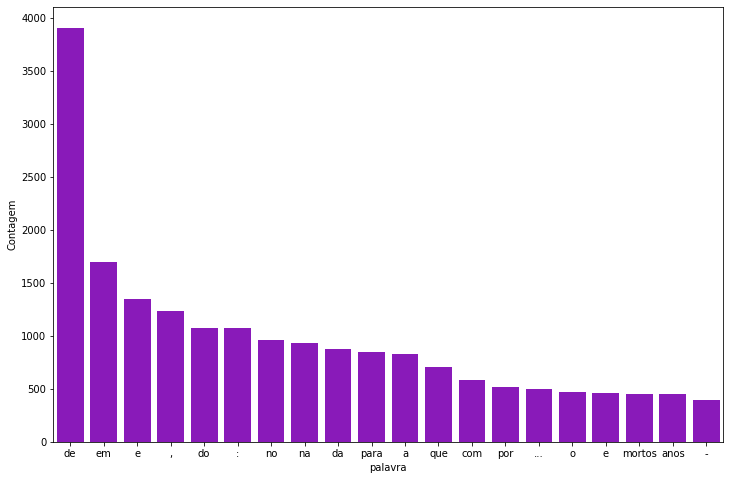

In [315]:
# Most frequent words in text
freq_words_plot(df_sentiments, 'text', 20)

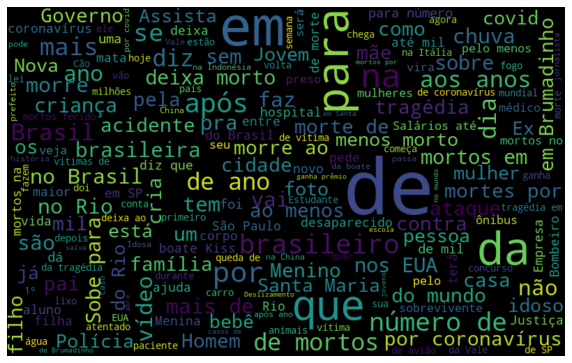

In [316]:
# Checking all the words densitys in text
word_cloud(df_sentiments, 'text')

In [317]:
# Adding term '(covid)' together with 'Coronavírus'
for index, row in df_sentiments.iterrows():
    if row['sentiment'] == 0:
        if 'coronavirus' in unidecode(row['text']).lower():
            df_sentiments.text[index] = unidecode(row['text']).lower()
            df_sentiments.text[index] = df_sentiments.text[index].replace('coronavirus', 
                                                                          'coronavirus (covid)')

In [318]:
# Building the stopwords lists

stop_words = nltk.corpus.stopwords.words('portuguese')
punctuations = [x for x in punctuation]
stop_words.extend(punctuations)  # Adding punctuations to stopwords 
stop_words.extend(['–', '...', 'brasil', '1a', '1o', 'brasileira', 'brasileiras',
                   'vai', 'mil', 'df', 'vão', 'brasileiro', 'brasileiros'])  # Chars identified in text
stop_words = [unidecode(char) for char in stop_words]  # Removing word's accents
stop_words = list(set(stop_words))  # Removing any duplicate

In [319]:
# Applying stopwords, unidecode and stem to text
transform_text(df_sentiments, 'text', stop_words, 'transformed_text')
df_sentiments.head()

,text,sentiment,transformed_text
0,Sobe para 41 o número de mortos na Baixada San...,0,sob 41 numer mort baix sant
1,"Vítimas de Suzano, Brumadinho e da Boate Kiss:...",0,vit suzan brum boat kis dor traum
2,A revolta da mãe de vítima do Ninho do Urubu u...,0,revolt mae vit ninh urubu ano apo incendi
3,Ninho do Urubu: famílias ainda aguardam indeni...,0,ninh urubu famil aind aguard indenizaca
4,Artigo: ‘O que fazer para evitar novas tragédi...,0,artig faz evit nov traged brum


In [320]:
# Saving the transformed text
df_sentiments.to_csv('dataset_nlp.csv')

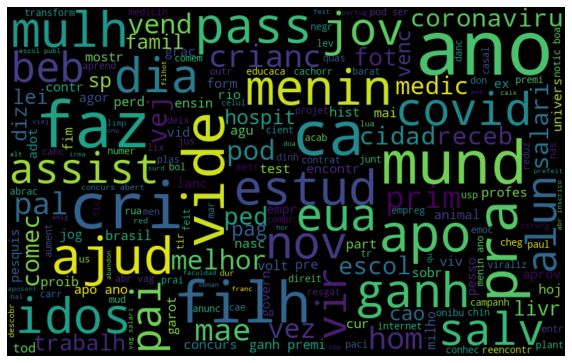

In [321]:
# Positive sentiments WordCloud
word_cloud(df_sentiments, 'transformed_text', query=True, query_code='sentiment == 1')

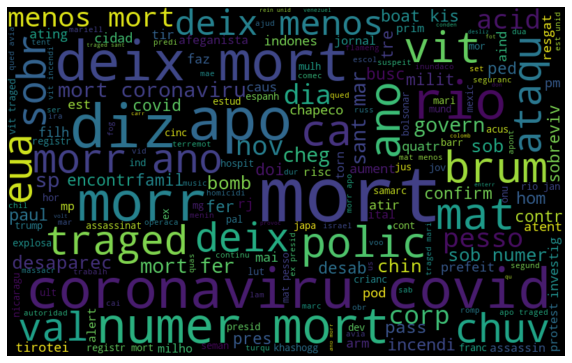

In [322]:
# Negative sentiments WordCloud
word_cloud(df_sentiments, 'transformed_text', query=True, query_code='sentiment == 0')

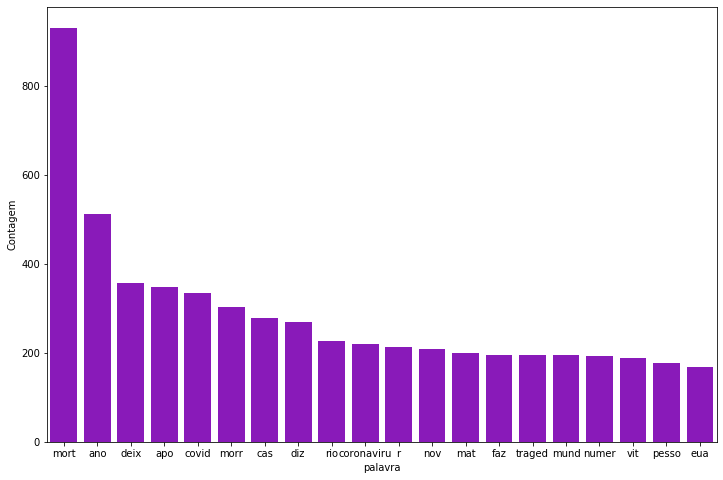

In [323]:
freq_words_plot(df_sentiments, 'transformed_text', 20)

In [324]:
# Baseline - Comparison algorithm

vectorize_dummy = CountVectorizer()
bag_of_words = vectorize_dummy.fit_transform(df_sentiments['transformed_text'])
    
SEED = 36

x_train, x_test, y_train, y_test = train_test_split(bag_of_words, 
                                                    df_sentiments['sentiment'],
                                                    test_size = 0.25,
                                                    stratify = df_sentiments['sentiment'],
                                                    random_state = SEED)

model_baseline = DummyClassifier()
model_baseline.fit(x_train, y_train)
accuracy_baseline = model_baseline.score(x_test, y_test)


print(f'Acurácia de: {accuracy_baseline * 100:.2f}%')

Acurácia de: 50.56%


In [325]:
# Training and testing the model

vectorize_tfidf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
tfidf = vectorize_tfidf.fit_transform(df_sentiments['transformed_text'])
   
SEED = 36

x_train, x_test, y_train, y_test = train_test_split(tfidf, 
                                                    df_sentiments['sentiment'],
                                                    test_size = 0.25,
                                                    stratify = df_sentiments['sentiment'],
                                                    random_state = SEED)

model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
accuracy_model = model.score(x_test, y_test)


print(f'Acurácia de: {accuracy_model * 100:.2f}%')

Acurácia de: 92.26%


In [326]:
# Checking the weight of positive words

weight_positive_words = pd.DataFrame(
    model.coef_[0].T,
    index = vectorize_tfidf.get_feature_names()
)

weight_positive_words.nlargest(50, 0)

,0
cri,3.403115
pra,2.842208
salari,2.581453
mund,2.395904
ganh,2.383701
melhor,2.241605
faz,2.194533
premi,2.136036
idos,2.038523
vir,1.998043


In [327]:
# Checking the weight of negative words

weight_negative_words = pd.DataFrame(
    model.coef_[0].T,
    index = vectorize_tfidf.get_feature_names()
)

weight_negative_words.nsmallest(50, 0)

,0
mort,-9.888708
morr,-7.003449
traged,-4.649280
mat,-4.169298
diz,-4.091597
deix,-3.643825
brum,-3.613045
vit,-3.564180
coronaviru covid,-3.152278
rio,-2.992874


In [328]:
# Testing some news with model

tests = ['Brasil tem 72.921 mortes e mais de 1,8 milhão de casos',
          'Lei que multa quem não usar máscara no estado do RJ começa a valer',
          'Carnaval de Salvador pode ser adiado se não houver vacina, diz prefeito',
          'Governo deposita hoje mais R$ 15 bi para estados e municípios',
          'Casa de PC Siqueira é alvo da polícia após acusação de pornografia infantil',
          'Brasileira é salva por método de ventilação que ela própria criou',
          'SP libera aulas de idioma com até 35% da capacidade',
          'Peritos vão ao prédio de jovem picado por naja e analisam imagens',
          'SP ultrapassa 19 mil mortes por covid e 400 mil casos',
          'Governo divulga calendário de novos pagamentos do auxílio emergencial',
          'Piracicaba recua à fase mais restritiva da flexibilização em SP',
          '3,5 mil empresas pedirão recuperação judicial ou irão à falência, projeta estudo',
          'Brasil tem 76,9 mil mortes e mais de 2 milhões de casos',
          'ANDRÉIA SADI: Aliados de Bolsonaro defendem "solução Weintraub" para Salles',
          'Médico da Fiocruz diz que pedido do governo sobre cloroquina é pouco profissional',
          'Prefeitura de SP cancela festa de réveillon na Paulista',
          'Escolas em Manaus têm rodízio de alunos e escudo facial',
          'Brasil tem 76,9 mil mortes e mais de 2 milhões de casos',
          'Live às 19h30 debate ciência e saúde pública após a pandemia',
          'Paula Toller, Angela Ro Ro, Roberta Sá e mais shows para ver em casa',
          'Número de desempregados no Brasil cresce 26% em meio à pandemia',
          'Golpista tenta cobrar propina para "liberar" testes importados de Covid',
          'Rambo da Floresta Negra é preso pela polícia alemã',
          'Região Sul tem mais de 11 mil casos de Covid em frigoríficos, diz MPT',
          ]
          

model_lr = vectorize_tfidf.transform(tests)

for t, c in zip (tests,model.predict(model_lr)):
    # t is the texto and c is the classification of each text
    print(f'{t}: {c}') 



Brasil tem 72.921 mortes e mais de 1,8 milhão de casos: 1
Lei que multa quem não usar máscara no estado do RJ começa a valer: 1
Carnaval de Salvador pode ser adiado se não houver vacina, diz prefeito: 0
Governo deposita hoje mais R$ 15 bi para estados e municípios: 1
Casa de PC Siqueira é alvo da polícia após acusação de pornografia infantil: 1
Brasileira é salva por método de ventilação que ela própria criou: 1
SP libera aulas de idioma com até 35% da capacidade: 1
Peritos vão ao prédio de jovem picado por naja e analisam imagens: 1
SP ultrapassa 19 mil mortes por covid e 400 mil casos: 0
Governo divulga calendário de novos pagamentos do auxílio emergencial: 1
Piracicaba recua à fase mais restritiva da flexibilização em SP: 1
3,5 mil empresas pedirão recuperação judicial ou irão à falência, projeta estudo: 1
Brasil tem 76,9 mil mortes e mais de 2 milhões de casos: 0
ANDRÉIA SADI: Aliados de Bolsonaro defendem "solução Weintraub" para Salles: 1
Médico da Fiocruz diz que pedido do gover

In [329]:
# Testing probability of some news with model

model_lr_prob = vectorize_tfidf.transform(tests)

for p in model.predict_proba(model_lr_prob):
    # t is the texto and c is the classification of each text
    polarity = p.tolist()
    polarity_neg = polarity[0]
    polarity_pos = polarity[1]
    print(f'Negativa: {polarity_neg * 100:.1f}%, Positiva: {polarity_pos * 100:.1f}%') 

Negativa: 48.8%, Positiva: 51.2%
Negativa: 18.0%, Positiva: 82.0%
Negativa: 89.4%, Positiva: 10.6%
Negativa: 46.5%, Positiva: 53.5%
Negativa: 35.6%, Positiva: 64.4%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 22.5%, Positiva: 77.5%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 60.0%, Positiva: 40.0%
Negativa: 18.0%, Positiva: 82.0%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 50.7%, Positiva: 49.3%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 71.5%, Positiva: 28.5%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 50.7%, Positiva: 49.3%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 36.5%, Positiva: 63.5%
Negativa: 48.4%, Positiva: 51.6%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 40.2%, Positiva: 59.8%
Negativa: 86.2%, Positiva: 13.8%


In [330]:
# Testing some news with dummy model

dummy_model = vectorize_dummy.transform(tests)

for t, c in zip (tests,model_baseline.predict(dummy_model)):
    # t is the texto and c is the classification of each text
    print(f'{t}: {c}') 

Brasil tem 72.921 mortes e mais de 1,8 milhão de casos: 1
Lei que multa quem não usar máscara no estado do RJ começa a valer: 0
Carnaval de Salvador pode ser adiado se não houver vacina, diz prefeito: 0
Governo deposita hoje mais R$ 15 bi para estados e municípios: 1
Casa de PC Siqueira é alvo da polícia após acusação de pornografia infantil: 0
Brasileira é salva por método de ventilação que ela própria criou: 1
SP libera aulas de idioma com até 35% da capacidade: 0
Peritos vão ao prédio de jovem picado por naja e analisam imagens: 1
SP ultrapassa 19 mil mortes por covid e 400 mil casos: 0
Governo divulga calendário de novos pagamentos do auxílio emergencial: 0
Piracicaba recua à fase mais restritiva da flexibilização em SP: 0
3,5 mil empresas pedirão recuperação judicial ou irão à falência, projeta estudo: 0
Brasil tem 76,9 mil mortes e mais de 2 milhões de casos: 0
ANDRÉIA SADI: Aliados de Bolsonaro defendem "solução Weintraub" para Salles: 0
Médico da Fiocruz diz que pedido do gover

In [332]:
joblib.dump(model, 'model_nlp.pyl')

['model_nlp.pyl']

In [ ]:
joblib.dump(vectorize_tfidf, 'vectorize_tfidf.pyl')